# Lesson 3: Chemical reactions

Since version 4.0, CADET also supports chemical reactions which can be used in all unit operations. In this lesson, we will learn how to:
- Model different reaction systems
- Associate reactions with different unit operations

<div class="alert alert-info">

**Note:** 
    
Currently, CADET does not support reactions in rapid equilibrium. 
Assuming $k_{eq} = \frac{k_{fwd}}{k_{bwd}}$, this can be approximated by keeping the ratio of both constants constant and scaling them up by a large factor.
    
</div>

## Load CADETSettings

This imports all the standard libraries and provides some helper functions.

In [1]:
%run ../utils.ipynb

## Example 1: Forward reaction

Let us consider the following batch reaction in a `CSTR` (without ingoing or outgoing streams):

$\require{mhchem}$
$$\ce{A ->[k_{AB}] B}$$

For modelling reactions, we need to provide the following information (see also [reaction modelling](https://cadet.github.io/modelling/reactions), and [reaction config](https://cadet.github.io/interface/reactions)).

- Stoichiometric matrix: coefficients of the forward reactions as $n_{components} \times n_{reactions}$.
- Reaction rates
    - kfwd: Rate constant for forward reactions
    - kbwd: Rate constant for backward reactions

In this case, the stoichiometric coefficients are $-1$ for $\left[A \right]$ and $1$ for $\left[B \right]$.
The stoichiometric matrix can hence be written as 
$\left[ \begin{array}{rrr} 
-1 \\ 
 1 \\ 
\end{array}\right]$

The forward rate of the reaction `kfwd` is $k_{AB}$ and because no backwards reaction is assumed, the backwards `kbwd` rate can be set to $0$.

In [2]:
# Auxiliary variables
t_cycle = 100

init_c = [1.0, 0.0]
V = 1e-6

kfwd = [0.1]
kbwd = [0.0]

stoich = [-1, 
           1]

We then procede configuring the CADET model.
Note that it is generally possible to specify different reactions in different phases (i.e. bulk phase, particle liquid phase, particle solid phase). Since the `CSTR` supports particles, we have to specify the reaction in the `input/model/unit_xxx/reaction_bulk` group.

Simulation completed successfully


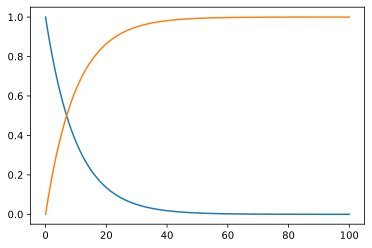

In [3]:
model = get_cadet_template(n_units=1)

n_comp = len(init_c)

# CSTR
model.root.input.model.unit_000.unit_type = 'CSTR'
model.root.input.model.unit_000.ncomp = n_comp
model.root.input.model.unit_000.init_volume = V
model.root.input.model.unit_000.init_c = init_c

model.root.input.model.unit_000.adsorption_model = 'NONE'

# Reaction
model.root.input.model.unit_000.reaction_model = 'MASS_ACTION_LAW'
model.root.input.model.unit_000.reaction_bulk.mal_kfwd_bulk = kfwd
model.root.input.model.unit_000.reaction_bulk.mal_kbwd_bulk = kbwd
model.root.input.model.unit_000.reaction_bulk.mal_stoichiometry_bulk = stoich 

# Sections and Switches
model.root.input.solver.sections.nsec = 1
model.root.input.solver.sections.section_times = [0.0, t_cycle]

model.root.input.model.connections.nswitches = 1
model.root.input.model.connections.switch_000.section = 0
model.root.input.model.connections.switch_000.connections = []


# Run simulation and plot results
run_simulation(model)

time = model.root.output.solution.solution_times
solution_outlet = model.root.output.solution.unit_000.solution_outlet
plt.plot(time, solution_outlet)

## Example 2: Equilibrium reaction

We will consider again consider a batch reaction in a `CSTR` but this time, we will also account for the backward reaction:

$\require{mhchem}$
$$\ce{ A <=>[k_{AB}][k_{BA}] B}$$

In [4]:
# Auxiliary variables
t_cycle = 100

init_c = [1.0, 0.0]
V = 1e-6

kfwd = [0.1]
kbwd = [0.01]

stoich = [-1, 
           1]

The rest of the setup is equivalent to Example 1

Simulation completed successfully


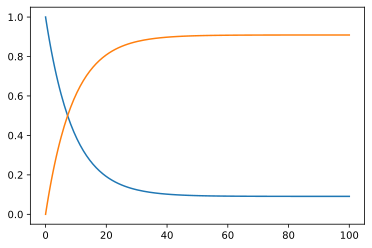

In [5]:
model = get_cadet_template(n_units=1)

n_comp = len(init_c)

# CSTR
model.root.input.model.unit_000.unit_type = 'CSTR'
model.root.input.model.unit_000.ncomp = 2
model.root.input.model.unit_000.init_volume = V
model.root.input.model.unit_000.init_c = init_c

model.root.input.model.unit_000.adsorption_model = 'NONE'

# Reaction
model.root.input.model.unit_000.reaction_model = 'MASS_ACTION_LAW'
model.root.input.model.unit_000.reaction_bulk.mal_kfwd_bulk = kfwd
model.root.input.model.unit_000.reaction_bulk.mal_kbwd_bulk = kbwd
model.root.input.model.unit_000.reaction_bulk.mal_stoichiometry_bulk = stoich 

# Sections and Switches
model.root.input.solver.sections.nsec = 1
model.root.input.solver.sections.section_times = [0.0, t_cycle]

model.root.input.model.connections.nswitches = 1
model.root.input.model.connections.switch_000.section = 0
model.root.input.model.connections.switch_000.connections = []


# Run simulation and plot results
run_simulation(model)

time = model.root.output.solution.solution_times
solution_outlet = model.root.output.solution.unit_000.solution_outlet
plt.plot(time, solution_outlet)

## Example 3
In this example, we will again consider the equilbrium reaction from Example 2, but this time we will implement it as a reaction in a column with length $0.5~m$ and cross section area $0.1~m^2$ that is fed with a concentration of $c_A = 1.0~g/L, c_B = 0.0~g/L$ and a flow rate of $1~L/min$.

In [6]:
# Auxiliary variables
t_cycle = 100

c_feed = [1.0, 0.0]
Q = 1e-3

kfwd = [0.1]
kbwd = [0.01]

stoich = [-1, 
           1]

For the column, we will use the 'LUMPED_RATE_MODEL_WITH_PORES'.
In order to save us some typing, the `discretization` parameters can be set with another utils function.

Simulation completed successfully


Text(0.5, 1.0, 'Column (Outlet)')

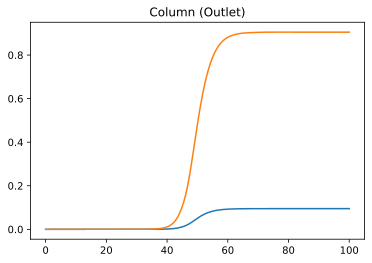

In [10]:
n_comp = len(c_feed)

model = get_cadet_template(n_units=3)

# Unit Operations
## Inlet
model.root.input.model.unit_000.unit_type = 'INLET'
model.root.input.model.unit_000.ncomp = n_comp
model.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

model.root.input.model.unit_000.sec_000.const_coeff = c_feed
model.root.input.model.unit_000.sec_000.lin_coeff = n_comp*[0.0]
model.root.input.model.unit_000.sec_000.quad_coeff = n_comp*[0.0]
model.root.input.model.unit_000.sec_000.cube_coeff = n_comp*[0.0]

# Tubular reactor
model.root.input.model.unit_001.unit_type = 'LUMPED_RATE_MODEL_WITH_PORES'
model.root.input.model.unit_001.ncomp = n_comp
model.root.input.model.unit_001.col_length = 0.5
model.root.input.model.unit_001.cross_section_area = 0.1
model.root.input.model.unit_001.col_porosity = 1
model.root.input.model.unit_001.par_porosity = 1
model.root.input.model.unit_001.par_radius = 1e-6
model.root.input.model.unit_001.col_dispersion = 0
model.root.input.model.unit_001.film_diffusion = n_comp * [0]
model.root.input.model.unit_001.init_c = n_comp * [0]

### Adsorption
model.root.input.model.unit_001.adsorption_model = 'NONE'

### Reaction
model.root.input.model.unit_001.reaction_model = 'MASS_ACTION_LAW'
model.root.input.model.unit_001.reaction_bulk.mal_kfwd_bulk = kfwd
model.root.input.model.unit_001.reaction_bulk.mal_kbwd_bulk = kbwd
model.root.input.model.unit_001.reaction_bulk.mal_stoichiometry_bulk = stoich

set_discretization(model)

## Outlet
model.root.input.model.unit_002.unit_type = 'OUTLET'
model.root.input.model.unit_002.ncomp = n_comp


## Sections and Switches
model.root.input.solver.sections.nsec = 1
model.root.input.solver.sections.section_times = [0.0, t_cycle]
model.root.input.solver.sections.section_continuity = []

model.root.input.model.connections.nswitches = 1
model.root.input.model.connections.switch_000.section = 0
model.root.input.model.connections.switch_000.connections = [0, 1, -1, -1, Q,
                                                             1, 2, -1, -1, Q]


# Run simulation and plot results
run_simulation(model)

plt.figure()
time = model.root.output.solution.solution_times
solution_outlet = model.root.output.solution.unit_001.solution_outlet
plt.plot(time, solution_outlet)
plt.title('Column (Outlet)')

Additionally to the solution at the inlet and outlet of a unit operation, we can also take a look inside the column to see how the concentration profiles change over the length of the column.

We find the solution of the liquid phase in the `/output/solution/unit_XXX/solution_bulk` group. 
The coordinates of a column are stored in `/output/coordinates/unit_XXX/axial_coordinates`.

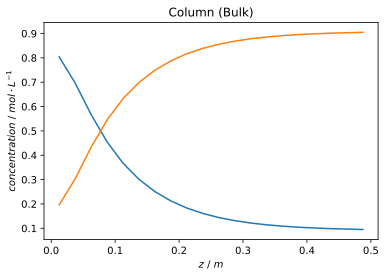

In [8]:
z = model.root.output.coordinates.unit_001.axial_coordinates
c = model.root.output.solution.unit_001.solution_bulk[-1,:,:]
plt.figure()
plt.plot(z, c)
plt.title('Column (Bulk)')
plt.xlabel('$z~/~m$')
plt.ylabel('$concentration~/~mol \cdot L^{-1} $')
plt.show()
